In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

We've talked about Random Forests. Now it's time to build one.

Here we'll use data from Lending Club to predict the state of a loan given some information about it. 

In [3]:
# Import data
y2015 = pd.read_csv(
    'LoanStats3d.csv',
    skipinitialspace=True,
    header=1
)


/Users/yunjin/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (0,19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
y2015.head()
y2015.shape

(421097, 145)

In [78]:
y2015['loan_status'].value_counts()

Fully Paid            297572
Charged Off            74762
Current                45863
Late (31-120 days)      1728
In Grace Period          633
Late (16-30 days)        414
Default                  123
Name: loan_status, dtype: int64


## Data Cleaning

Mixed data types get converted to objects, and that could create huge problems. Our dataset is about 400,000 rows. If there's a bad type there its going to see 400,000 distinct values and try to create dummies for all of them. That's bad. Lets look at all our categorical variables and see how many distinct counts there are...

In [4]:
categorical = y2015.select_dtypes(include=['object'])
for i in categorical:
    column = categorical[i]
    print(i)
    print(column.nunique())

id
2
term
2
int_rate
111
grade
7
sub_grade
35
emp_title
120812
emp_length
11
home_ownership
4
verification_status
3
issue_d
12
loan_status
7
pymnt_plan
2
desc
34
purpose
14
title
27
zip_code
914
addr_state
49
earliest_cr_line
668
revol_util
1211
initial_list_status
2
last_pymnt_d
50
next_pymnt_d
6
last_credit_pull_d
51
application_type
2
verification_status_joint
1
hardship_flag
2
hardship_type
1
hardship_reason
9
hardship_status
3
hardship_start_date
25
hardship_end_date
25
payment_plan_start_date
25
hardship_loan_status
4
disbursement_method
1
debt_settlement_flag
2
debt_settlement_flag_date
43
settlement_status
3
settlement_date
46


In [5]:
categorical

,id,term,int_rate,grade,sub_grade,emp_title,emp_length,home_ownership,verification_status,issue_d,...,hardship_status,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_loan_status,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date
0,NaN,60 months,14.85%,C,C5,Information Systems Officer,10+ years,MORTGAGE,Source Verified,Dec-2015,...,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN
1,NaN,60 months,22.45%,F,F1,Contract Specialist,3 years,MORTGAGE,Source Verified,Dec-2015,...,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN
2,NaN,60 months,10.78%,B,B4,truck driver,10+ years,MORTGAGE,Not Verified,Dec-2015,...,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN
3,NaN,36 months,13.99%,C,C4,leadman,10+ years,MORTGAGE,Not Verified,Dec-2015,...,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN
4,NaN,36 months,11.99%,C,C1,Engineer,10+ years,MORTGAGE,Not Verified,Dec-2015,...,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN
5,NaN,36 months,13.44%,C,C3,Veterinary Tecnician,4 years,RENT,Source Verified,Dec-2015,...,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN
6,NaN,60 months,12.88%,C,C2,Senior Structural Designer,1 year,MORTGAGE,Not Verified,Dec-2015,...,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN
7,NaN,36 months,9.17%,B,B2,Vice President of Recruiting Operations,10+ years,MORTGAGE,Not Verified,Dec-2015,...,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN
8,NaN,36 months,12.88%,C,C2,Logistics Manager,3 years,MORTGAGE,Not Verified,Dec-2015,...,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN
9,NaN,60 months,19.48%,E,E2,Software Manager,7 years,RENT,Not Verified,Dec-2015,...,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN


Some of these have over a hundred thousand distinct types. Lets drop the ones with over 30 unique values, converting to numeric where it makes sense. In doing this there's a lot of code that gets written to just see if the numeric conversion makes sense. It's a manual process that we'll abstract away and just include the conversion.

Extracting numeric features from the dates, but here we'll just drop them. There's a lot of data, it shouldn't be a huge problem.

In [6]:
# Convert ID and Interest Rate to numeric.
y2015['id'] = pd.to_numeric(y2015['id'], errors='coerce')
y2015['int_rate'] = pd.to_numeric(y2015['int_rate'].str.strip('%'), errors='coerce')

# Drop other columns with many unique variables
y2015.drop(['url', 'emp_title', 'zip_code', 'earliest_cr_line', 'revol_util',
            'sub_grade', 'addr_state', 'desc'], 1, inplace=True)

Wonder what was causing the dtype error on the id column, which _should_ have all been integers? Let's look at the end of the file.

In [35]:
y2015.tail()
y2015

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,10+ years,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,3 years,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,10+ years,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,10+ years,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,10+ years,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,11950.0,11950.0,11950.0,36 months,13.44,405.18,C,4 years,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,16000.0,16000.0,16000.0,60 months,12.88,363.07,C,1 year,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,20000.0,20000.0,20000.0,36 months,9.17,637.58,B,10+ years,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,1400.0,1400.0,1400.0,36 months,12.88,47.10,C,3 years,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,18000.0,18000.0,18000.0,60 months,19.48,471.70,E,7 years,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# Remove two summary rows at the end that don't actually contain data.
y2015 = y2015[:-2]

Now this should be better. Let's try again.

It finally works! We had to sacrifice sub grade, state address and description, but that's fine. If you want to include them you could run the dummies independently and then append them back to the dataframe.

## Second Attempt

Now let's try this model again.

We're also going to drop NA columns, rather than impute, because our data is rich enough that we can probably get away with it.

This model may take a few minutes to run.

In [8]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

rfc = ensemble.RandomForestClassifier()
X = y2015.drop('loan_status', 1)
Y = y2015['loan_status']
X = pd.get_dummies(X)
X = X.dropna(axis=1)

# cross_val_score(rfc, X, Y, cv=10)

In [14]:
rfc.fit(X,Y)
importances = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_],axis=0)
indices=np.argsort(importances)[::-1]

array([1.51706776e-02, 2.07734450e-02, 1.84403591e-02, 1.40670922e-02,
       1.45633308e-02, 1.56541759e-03, 3.67234667e-04, 5.18877193e-04,
       1.07209910e-03, 2.99498455e-04, 2.14964600e-03, 1.20798182e-03,
       8.27358049e-02, 2.06461135e-02, 2.43699075e-02, 4.64295707e-02,
       6.89973220e-02, 1.31012541e-02, 4.26697414e-03, 5.73930168e-02,
       1.54680938e-01, 7.61751205e-02, 1.09935067e-04, 0.00000000e+00,
       3.05587280e-05, 3.94681901e-04, 1.48890476e-03, 1.48798573e-03,
       1.62857618e-03, 1.44441336e-03, 4.17062153e-05, 3.90058203e-05,
       1.52022799e-03, 1.08259719e-03, 1.17699740e-03, 6.60686303e-04,
       4.24332177e-04, 7.96977032e-04, 1.08862798e-03, 9.21625714e-04,
       1.05767592e-03, 1.05526582e-03, 1.00779121e-03, 1.15841250e-03,
       1.04249867e-03, 2.59350979e-05, 1.59137698e-04, 9.52966443e-04,
       8.44866198e-04, 2.09591832e-04, 1.75873692e-04, 1.47095272e-03,
       1.35856231e-03, 1.46392304e-03, 1.19188926e-03, 1.27482517e-02,
      

Index(['collection_recovery_fee', 'out_prncp', 'last_pymnt_amnt',
       'next_pymnt_d_Feb-2019', 'total_rec_prncp', 'recoveries',
       'term_ 60 months', 'total_pymnt_inv', 'next_pymnt_d_Mar-2019',
       'total_pymnt'],
      dtype='object')

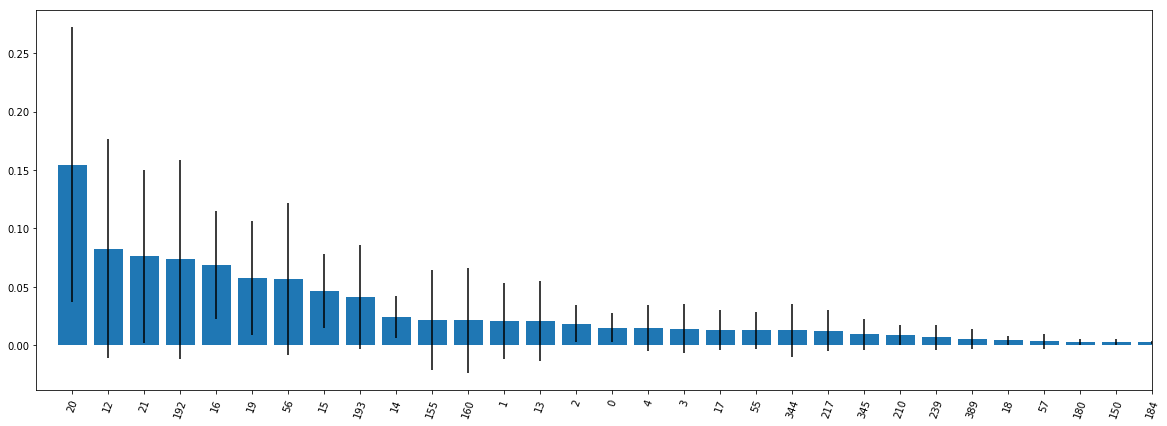

In [65]:
plt.figure(figsize=(20,7))
plt.bar(range(X.shape[1]), importances[indices], yerr=std[indices], align='center')
plt.xticks(range(X.shape[1]), indices,rotation=70)
plt.xlim(-1,30)

feature_importances = pd.DataFrame(importances, index = X.columns, columns=['importance']).sort_values('importance',ascending=False)
feature_importances.index[:10]

The score cross validation reports is the accuracy of the tree. Here we're about 98% accurate.

That works pretty well, but there are a few potential problems. Firstly, we didn't really do much in the way of feature selection or model refinement. As such there are a lot of features in there that we don't really need. Some of them are actually quite impressively useless.

There's also some variance in the scores. The fact that one gave us only 93% accuracy while others gave higher than 98 is concerning. This variance could be corrected by increasing the number of estimators. That will make it take even longer to run, however, and it is already quite slow.

## Challenge : Third attempt

So here's your task. Get rid of as much data as possible without dropping below an average of 90% accuracy in a 10-fold cross validation.

You'll want to do a few things in this process. First, dive into the data that we have and see which features are most important. This can be the raw features or the generated dummies. You may want to use PCA or correlation matrices.

Can you do it without using anything related to payment amount or outstanding principal? How do you know?

In [53]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Your code here.
df_pca=X

# Normalize the data 
X = StandardScaler().fit_transform(df_pca)

# numpy covariance function assumes that variables are represented by rows, not columns, so we transpose X
Xt=X.T
Cx=np.cov(Xt)

/Users/yunjin/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(0, 100)

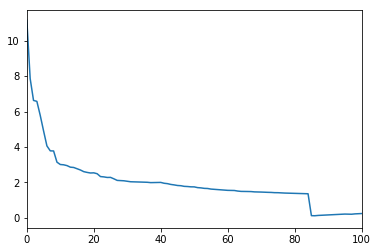

In [55]:
eig_val_cov, eig_vex_cov=np.linalg.eig(Cx)
plt.plot(eig_val_cov)
plt.xlim([0,100])

It seems that 1~20 components contains an amount of information equal to that of more than two variables. Therefore, first, we can try including only 20 components in our model.

In [56]:
pca = PCA(n_components=20)
pca.fit(X)
pca_comp=pca.transform(X)


In [57]:
rfc=ensemble.RandomForestClassifier()
cross_val_score(rfc,pca_comp,Y,cv=10)

array([0.91409033, 0.91967042, 0.92251615, 0.92426797, 0.92022894,
       0.92125012, 0.92343498, 0.91973022, 0.92488185, 0.92523808])

All scores are over 90%, so I decided to try including only 10 components 

In [58]:
pca= PCA(n_components=10)
pca.fit(X)
pca_comp=pca.transform(X)

cross_val_score(rfc,pca_comp,Y,cv=10)

array([0.92133257, 0.92563043, 0.92565065, 0.92179819, 0.91053956,
       0.92329249, 0.92737722, 0.92393369, 0.92623554, 0.92402688])

Still all scores are over 90% ... then how about using 9 components?

In [61]:
pca= PCA(n_components=9)
pca.fit(X)
pca_comp=pca.transform(X)

cross_val_score(rfc,pca_comp,Y,cv=10)

array([0.9195042 , 0.92325592, 0.9237272 , 0.91768981, 0.90571863,
       0.91965897, 0.92507362, 0.92096514, 0.92336191, 0.92336191])

In [63]:
pca= PCA(n_components=8)
pca.fit(X)
pca_comp=pca.transform(X)

cross_val_score(rfc,pca_comp,Y,cv=10)

array([0.66735527, 0.66837631, 0.6659147 , 0.66786198, 0.66443431,
       0.6653605 , 0.66281942, 0.66400684, 0.65867908, 0.65901157])

Scores dropped when using 8 components. Thus, the smallest number of component which result in 90% scores in cross validation is 9

In [ ]:
rfc.fit

## Can you do it without using anything related to payment amount or outstanding principal? How do you know?

/Users/yunjin/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(0, 100)

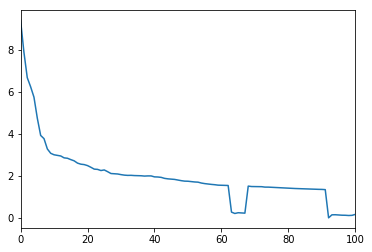

In [64]:
# Excluding features which are related to payment amount or outstanding principal

features_exc=['out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'hardship_last_payment_amount','installment',
              'out_prncp','out_prncp_inv','total_rec_prncp']
X = y2015.drop(features_exc, 1)
X = pd.get_dummies(X)
X = X.dropna(axis=1)

df_pca=X

# Normalize the data 
X = StandardScaler().fit_transform(df_pca)

# numpy covariance function assumes that variables are represented by rows, not columns, so we transpose X
Xt=X.T
Cx=np.cov(Xt)

eig_val_cov, eig_vex_cov=np.linalg.eig(Cx)
plt.plot(eig_val_cov)
plt.xlim([0,100])

In [66]:
pca= PCA(n_components=9)
pca.fit(X)
pca_comp=pca.transform(X)

cross_val_score(rfc,pca_comp,Y,cv=10)

array([0.99052572, 0.99014579, 0.99062025, 0.98952718, 0.98795953,
       0.99050062, 0.99116557, 0.99149805, 0.99230532, 0.99218657])

In [67]:
pca= PCA(n_components=8)
pca.fit(X)
pca_comp=pca.transform(X)

cross_val_score(rfc,pca_comp,Y,cv=10)

array([0.98857862, 0.98826993, 0.98959916, 0.98822105, 0.9845635 ,
       0.98829201, 0.98952693, 0.99014439, 0.99073788, 0.99071413])

In [68]:
pca= PCA(n_components=7)
pca.fit(X)
pca_comp=pca.transform(X)

cross_val_score(rfc,pca_comp,Y,cv=10)

array([0.98732013, 0.98653654, 0.98767572, 0.9865112 , 0.98128622,
       0.98553719, 0.98836326, 0.98841075, 0.98852922, 0.98869547])

In [69]:
pca= PCA(n_components=3)
pca.fit(X)
pca_comp=pca.transform(X)

cross_val_score(rfc,pca_comp,Y,cv=10)

array([0.93852401, 0.9373605 , 0.94122815, 0.93789926, 0.93637789,
       0.93635414, 0.9331006 , 0.9361404 , 0.93737383, 0.93597264])

In [72]:
pca= PCA(n_components=2)
pca.fit(X)
pca_comp=pca.transform(X)

cross_val_score(rfc,pca_comp,Y,cv=10)

array([0.79201691, 0.80066011, 0.80473499, 0.80042271, 0.80246034,
       0.79923055, 0.79870808, 0.7961195 , 0.80145819, 0.79989075])

After excluding those features, we could get even a lot smaller number of components (3) with over 90%.

# Grid Search

Instead of finding hyperparameters by hand, we can automate this process by using gridsearch.

In [47]:
# Import grid search module
from sklearn.model_selection import GridSearchCV

# Create parameter grid based on the parameters used above
param_grid = {
    'bootstrap':[True],
    'max_depth':[1,2,3,4,5],
    'max_features':[1,2,3],
    'n_estimators':[100,200,300,1000]
}

# Instantiate the grid search model
grid_search =GridSearchCV(estimator=rfc, param_grid=param_grid, cv=3,n_jobs=-1, verbose=2)

In [48]:
# Estimate the model. This will try out all of combinations of setting .
grid_search.fit(X,Y)

Fitting 3 folds for each of 60 candidates, totalling 180 fits
[CV] bootstrap=True, max_depth=1, max_features=1, n_estimators=100 ...
[CV] bootstrap=True, max_depth=1, max_features=1, n_estimators=100 ...
[CV] bootstrap=True, max_depth=1, max_features=1, n_estimators=100 ...
[CV] bootstrap=True, max_depth=1, max_features=1, n_estimators=200 ...
[CV]  bootstrap=True, max_depth=1, max_features=1, n_estimators=100, total=  14.6s
[CV] bootstrap=True, max_depth=1, max_features=1, n_estimators=200 ...
[CV]  bootstrap=True, max_depth=1, max_features=1, n_estimators=100, total=  18.1s
[CV] bootstrap=True, max_depth=1, max_features=1, n_estimators=200 ...
[CV]  bootstrap=True, max_depth=1, max_features=1, n_estimators=100, total=  18.8s
[CV] bootstrap=True, max_depth=1, max_features=1, n_estimators=300 ...
[CV]  bootstrap=True, max_depth=1, max_features=1, n_estimators=200, total=  19.7s
[CV] bootstrap=True, max_depth=1, max_features=1, n_estimators=300 ...
[CV]  bootstrap=True, max_depth=1, max

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  5.4min


[CV]  bootstrap=True, max_depth=2, max_features=1, n_estimators=100, total=   9.8s
[CV] bootstrap=True, max_depth=2, max_features=1, n_estimators=100 ...
[CV]  bootstrap=True, max_depth=2, max_features=1, n_estimators=100, total=  10.4s
[CV] bootstrap=True, max_depth=2, max_features=1, n_estimators=100 ...
[CV]  bootstrap=True, max_depth=2, max_features=1, n_estimators=100, total=  10.7s
[CV] bootstrap=True, max_depth=2, max_features=1, n_estimators=200 ...
[CV]  bootstrap=True, max_depth=1, max_features=3, n_estimators=1000, total= 1.2min
[CV] bootstrap=True, max_depth=2, max_features=1, n_estimators=200 ...
[CV]  bootstrap=True, max_depth=2, max_features=1, n_estimators=200, total=  18.5s
[CV] bootstrap=True, max_depth=2, max_features=1, n_estimators=200 ...
[CV]  bootstrap=True, max_depth=1, max_features=3, n_estimators=1000, total= 1.2min
[CV] bootstrap=True, max_depth=2, max_features=1, n_estimators=300 ...
[CV]  bootstrap=True, max_depth=2, max_features=1, n_estimators=200, total

[CV] bootstrap=True, max_depth=3, max_features=2, n_estimators=300 ...
[CV]  bootstrap=True, max_depth=3, max_features=2, n_estimators=200, total=  23.6s
[CV] bootstrap=True, max_depth=3, max_features=2, n_estimators=300 ...
[CV]  bootstrap=True, max_depth=3, max_features=1, n_estimators=1000, total= 1.3min
[CV] bootstrap=True, max_depth=3, max_features=2, n_estimators=300 ...
[CV]  bootstrap=True, max_depth=3, max_features=2, n_estimators=200, total=  22.9s
[CV] bootstrap=True, max_depth=3, max_features=2, n_estimators=1000 ..
[CV]  bootstrap=True, max_depth=3, max_features=2, n_estimators=300, total=  29.3s
[CV] bootstrap=True, max_depth=3, max_features=2, n_estimators=1000 ..
[CV]  bootstrap=True, max_depth=3, max_features=2, n_estimators=300, total=  28.7s
[CV] bootstrap=True, max_depth=3, max_features=2, n_estimators=1000 ..
[CV]  bootstrap=True, max_depth=3, max_features=2, n_estimators=300, total=  30.5s
[CV] bootstrap=True, max_depth=3, max_features=3, n_estimators=100 ...
[CV]

[CV]  bootstrap=True, max_depth=4, max_features=3, n_estimators=300, total=  36.5s
[CV] bootstrap=True, max_depth=5, max_features=1, n_estimators=100 ...
[CV]  bootstrap=True, max_depth=5, max_features=1, n_estimators=100, total=  12.6s
[CV] bootstrap=True, max_depth=5, max_features=1, n_estimators=100 ...
[CV]  bootstrap=True, max_depth=5, max_features=1, n_estimators=100, total=  12.4s
[CV] bootstrap=True, max_depth=5, max_features=1, n_estimators=100 ...
[CV]  bootstrap=True, max_depth=5, max_features=1, n_estimators=100, total=  13.0s
[CV] bootstrap=True, max_depth=5, max_features=1, n_estimators=200 ...
[CV]  bootstrap=True, max_depth=5, max_features=1, n_estimators=200, total=  21.5s
[CV] bootstrap=True, max_depth=5, max_features=1, n_estimators=200 ...
[CV]  bootstrap=True, max_depth=4, max_features=3, n_estimators=1000, total= 1.8min
[CV] bootstrap=True, max_depth=5, max_features=1, n_estimators=200 ...
[CV]  bootstrap=True, max_depth=5, max_features=1, n_estimators=200, total=

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 31.3min


[CV]  bootstrap=True, max_depth=5, max_features=2, n_estimators=100, total=  14.3s
[CV] bootstrap=True, max_depth=5, max_features=2, n_estimators=100 ...
[CV]  bootstrap=True, max_depth=5, max_features=2, n_estimators=100, total=  15.5s
[CV] bootstrap=True, max_depth=5, max_features=2, n_estimators=200 ...
[CV]  bootstrap=True, max_depth=5, max_features=1, n_estimators=1000, total= 1.5min
[CV] bootstrap=True, max_depth=5, max_features=2, n_estimators=200 ...
[CV]  bootstrap=True, max_depth=5, max_features=2, n_estimators=200, total=  28.3s
[CV] bootstrap=True, max_depth=5, max_features=2, n_estimators=200 ...
[CV]  bootstrap=True, max_depth=5, max_features=1, n_estimators=1000, total= 1.5min
[CV] bootstrap=True, max_depth=5, max_features=2, n_estimators=300 ...
[CV]  bootstrap=True, max_depth=5, max_features=1, n_estimators=1000, total= 1.6min
[CV] bootstrap=True, max_depth=5, max_features=2, n_estimators=300 ...
[CV]  bootstrap=True, max_depth=5, max_features=2, n_estimators=200, tota

[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 39.1min finished


{'bootstrap': True, 'max_depth': 5, 'max_features': 3, 'n_estimators': 100}

In [58]:
print('Best parameters are ',grid_search.best_params_)
print('Best score is ',grid_search.best_score_)

Best parameters are  {'bootstrap': True, 'max_depth': 5, 'max_features': 3, 'n_estimators': 100}
Best score is  0.706664766857835
